# 0. Loading packages

Uncomment cell below if not all necessary packages are installed

In [1]:
# Install necessary packages
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install seaborn
# %pip install scikit-learn
# %pip install missingno
# %pip install imblearn
# %pip install xgboost

In [3]:
import warnings

warnings.filterwarnings('ignore')

from self_functions import DataVisualizer, DataPreprocessor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                               GradientBoostingClassifier, 
                               VotingClassifier)
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


# 1. Loading data

In [6]:
train_data = pd.read_csv('Datasets/train.csv')
test_data = pd.read_csv('Datasets/test.csv')
test_data_ids = test_data['id']

# 2. Inspecting data

## 2.1 Inspecting missing data

<Axes: >

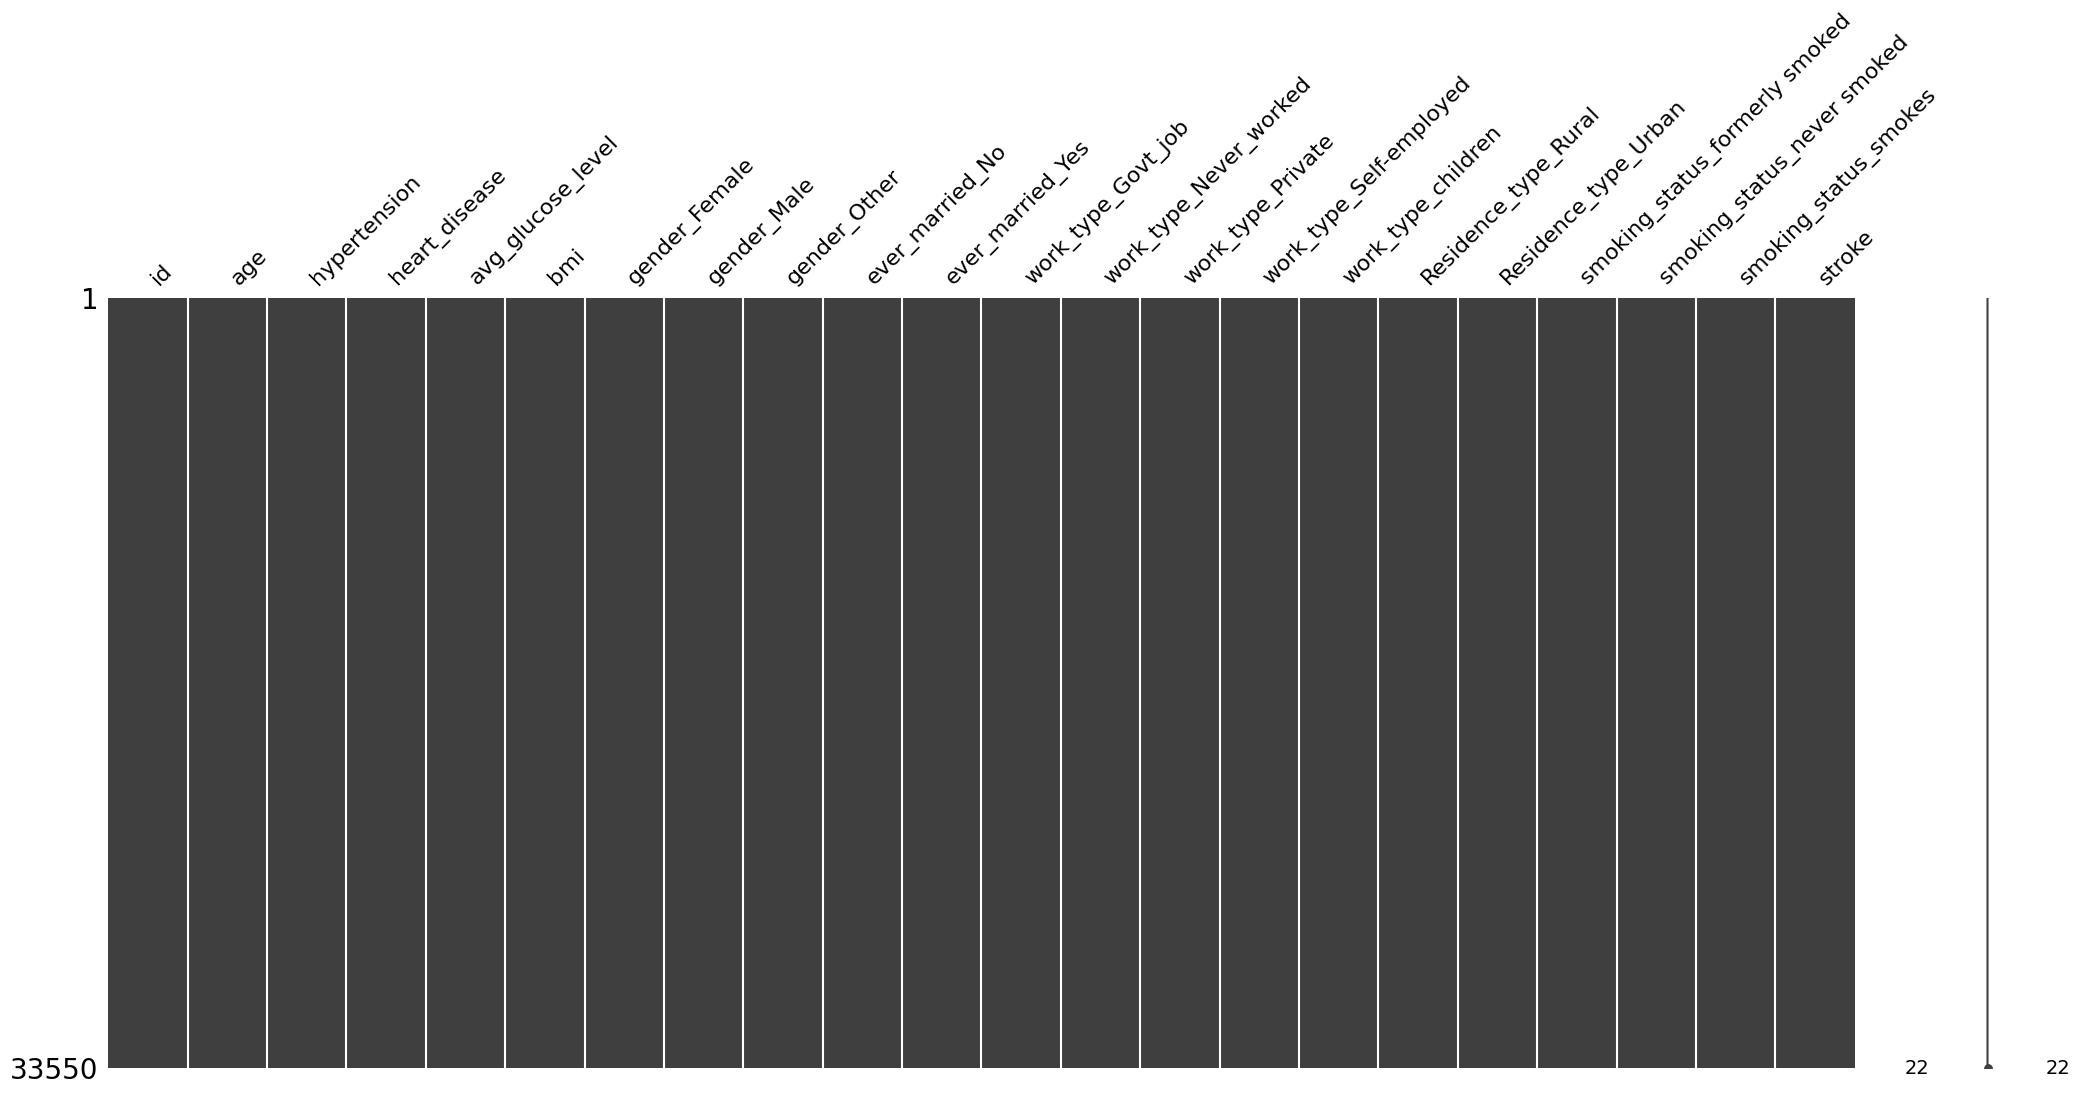

In [4]:
msno.matrix(train_data)

There is no missing data in the train dataset

<Axes: >

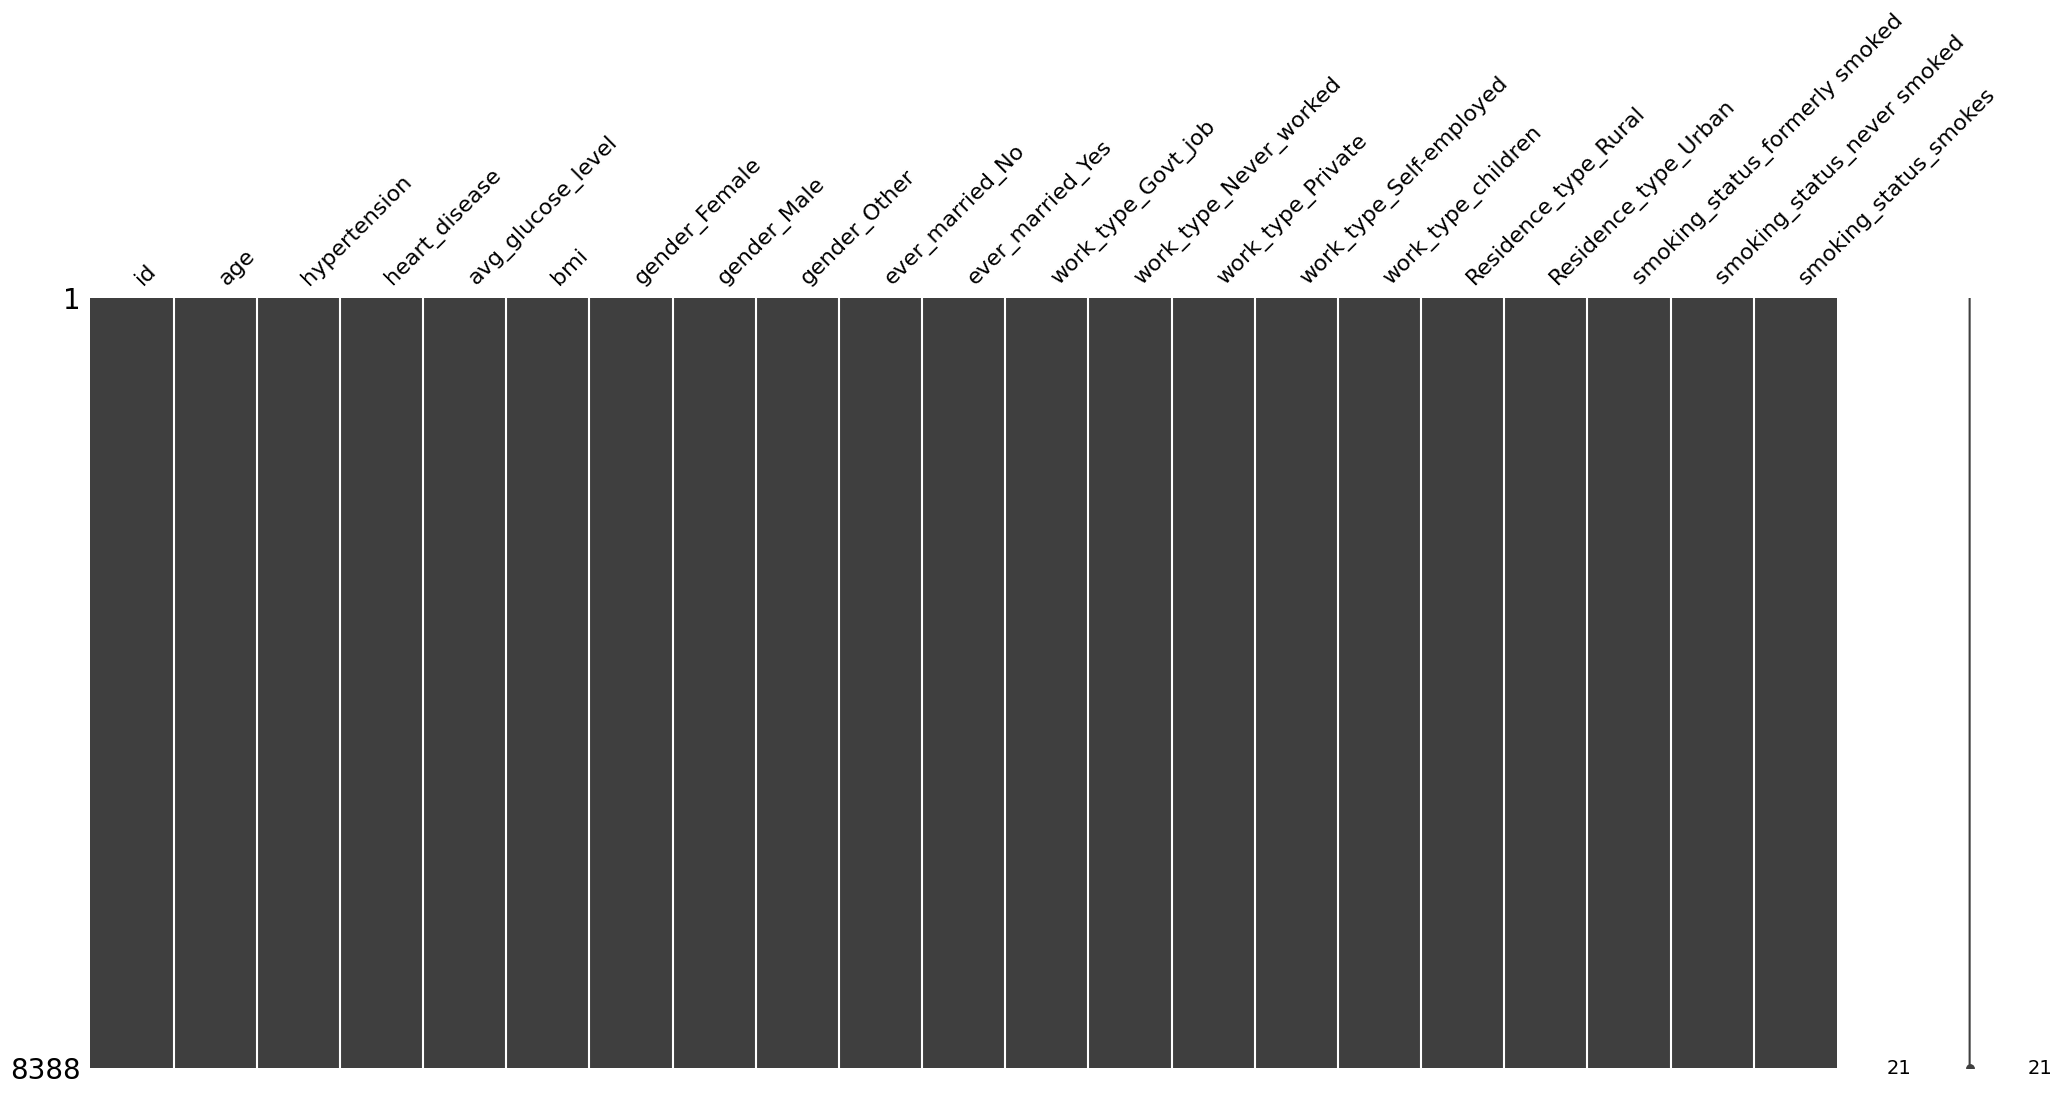

In [5]:
msno.matrix(test_data)

There is no missing data in the test dataset

## 2.2 Inspecting individual columns

In [6]:
visualizer = DataVisualizer()

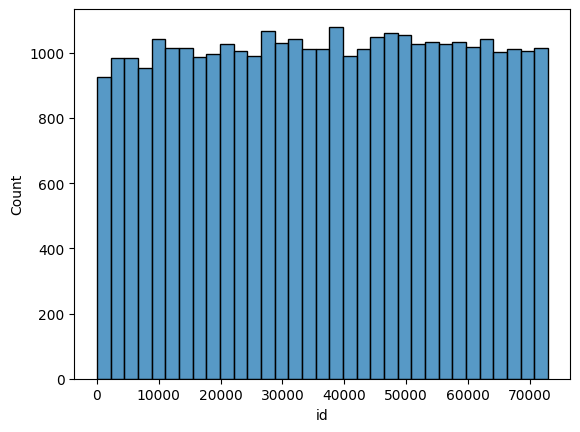

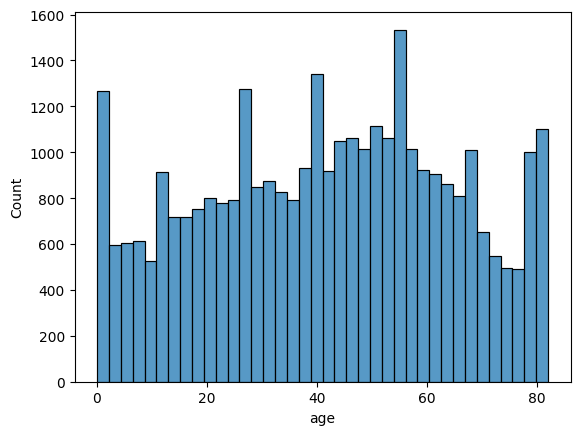

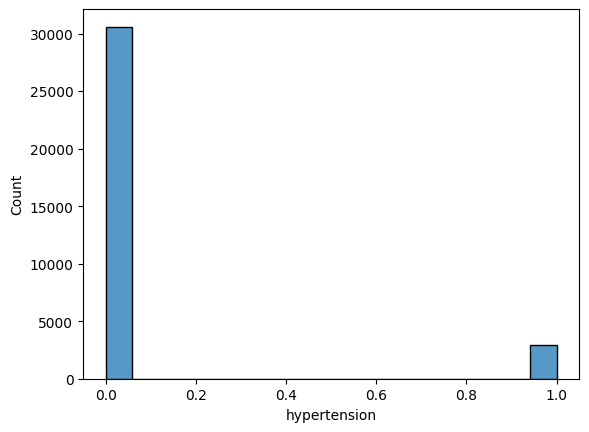

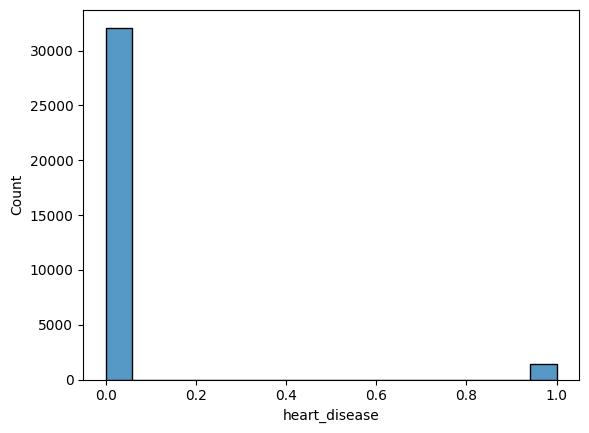

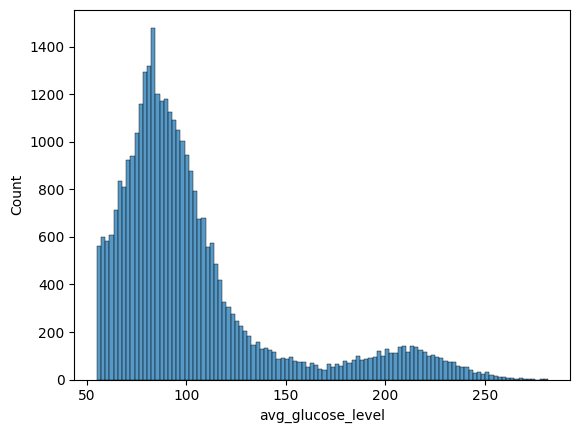

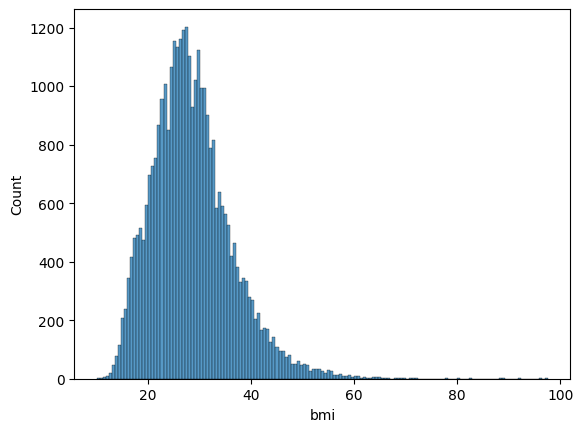

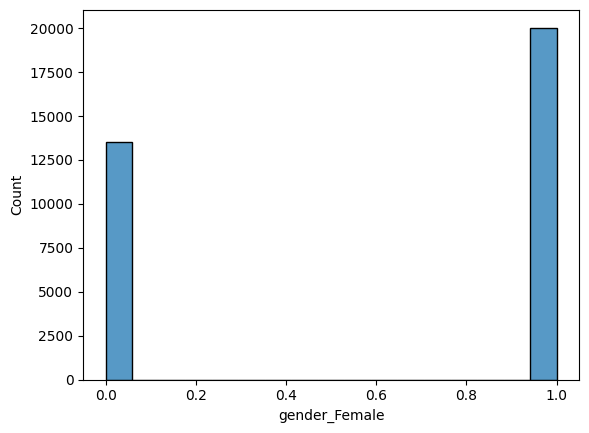

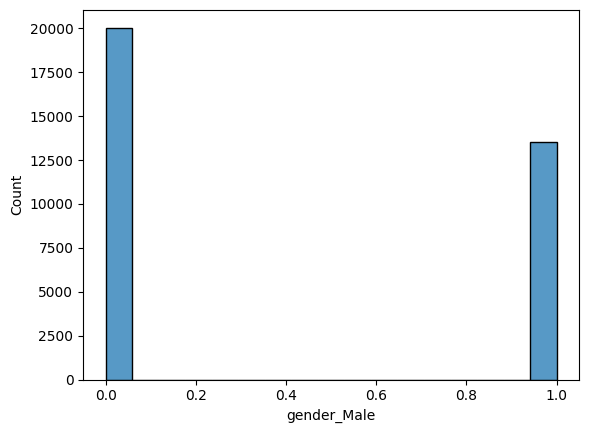

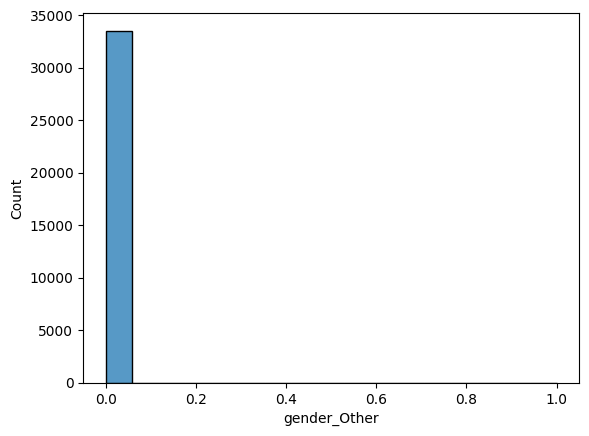

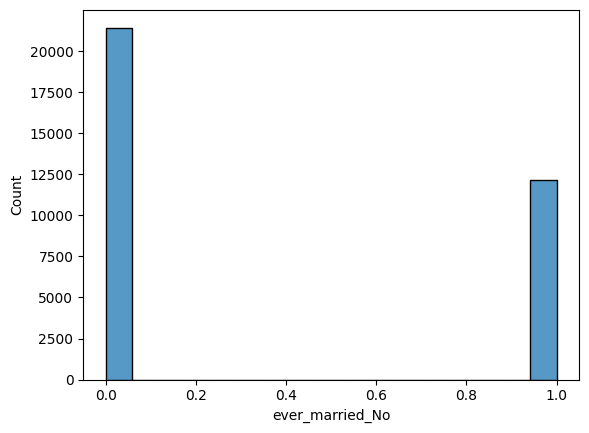

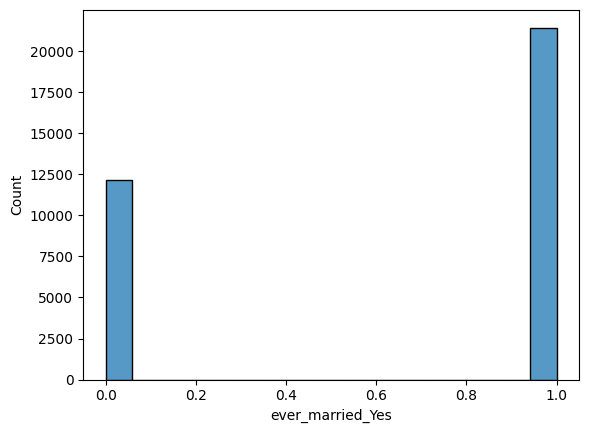

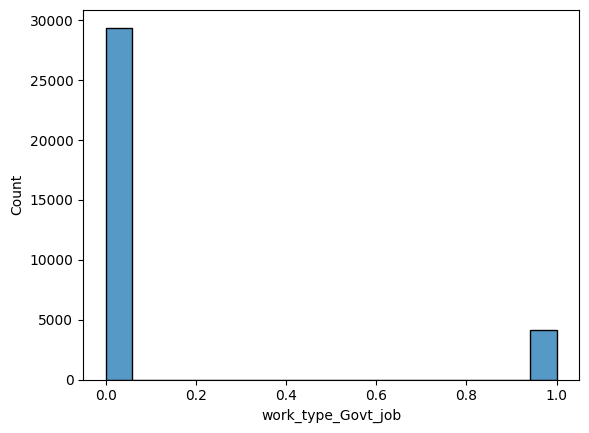

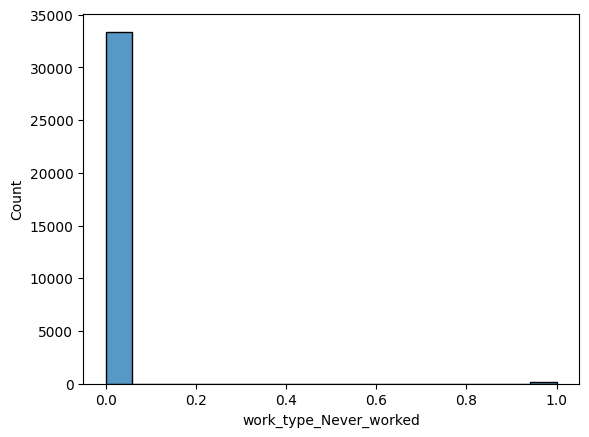

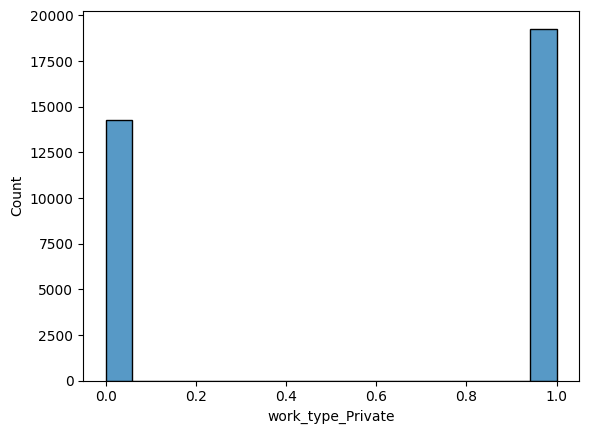

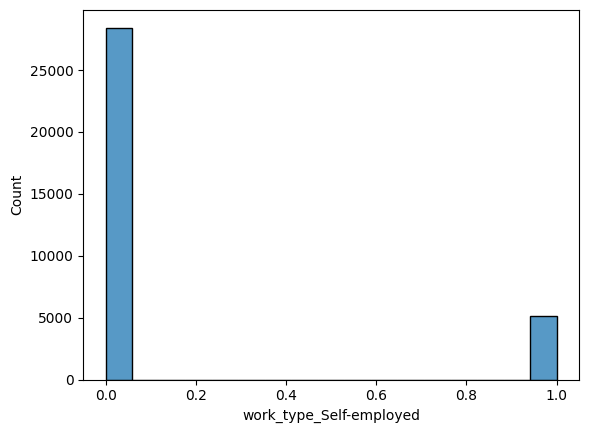

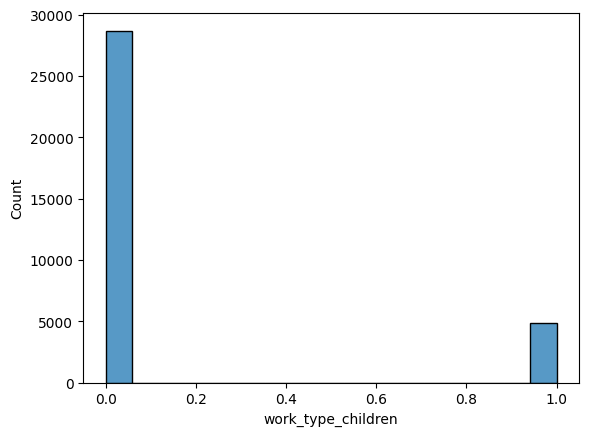

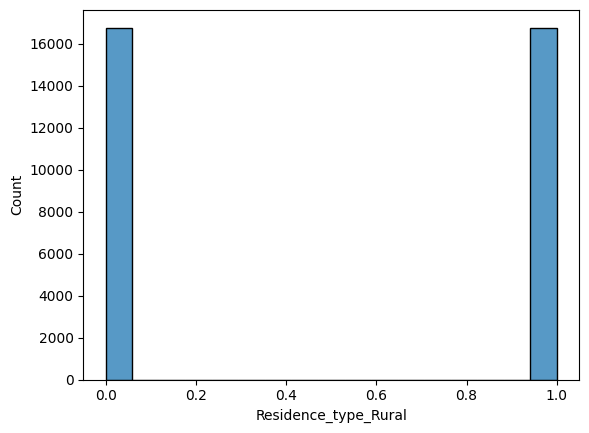

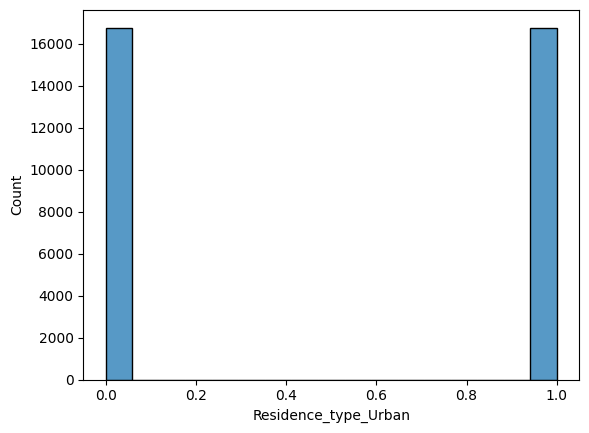

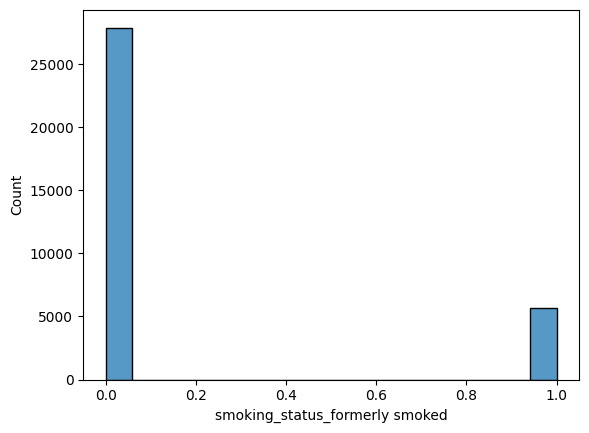

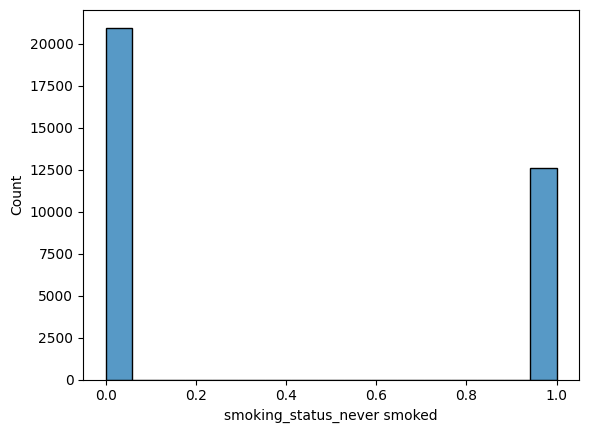

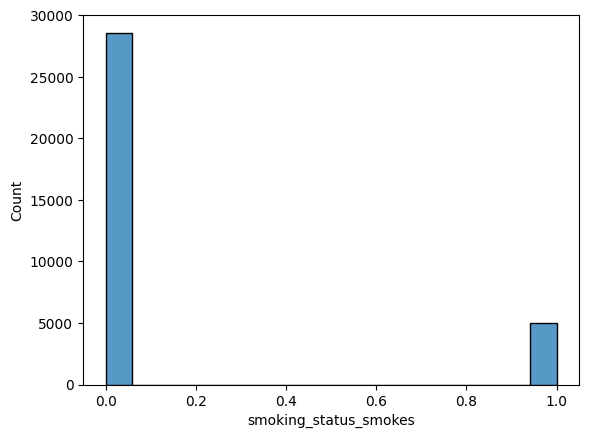

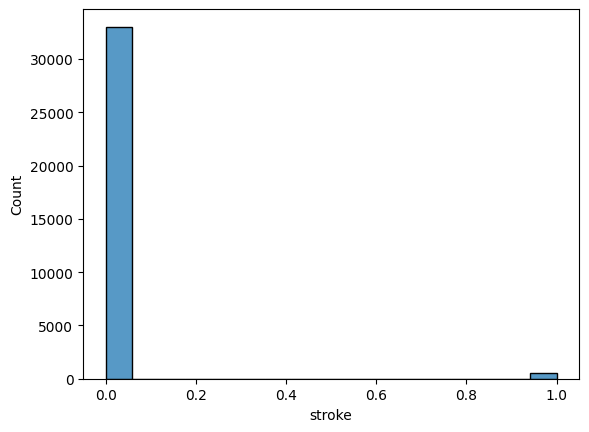

In [7]:
for column in train_data.columns:
    visualizer.histplot(train_data[column])

The dataset reveals several important trends and distributions related to key health and demographic attributes:

- **Hypertension and Heart Disease**: There is a relatively low prevalence of diagnosed hypertension and heart disease among individuals in the dataset.

- **Glucose and BMI Distributions**: Both average glucose levels and BMI exhibit right-skewed distributions, indicating a higher frequency of individuals with values below the mean but a tail extending towards higher values.

- **Gender Distribution**: The dataset contains a higher proportion of women compared to men, with no entries for individuals identifying outside of these categories.

- **Employment Sector**: The majority of individuals are employed by private companies, making this the most represented employment sector in the dataset.

- **Urban vs. Rural Residence**: The distribution of individuals by area of residence is balanced, with approximately 50% living in rural areas and 50% in urban areas.

- **Smoking Status**: Smoking history among individuals is also balanced; about half of the individuals have smoked at some point in their lives. Among those who have smoked, there is a roughly equal split between current smokers and former smokers.

- **Stroke Occurrence**: The dataset contains a low number of individuals with a history of stroke, creating a class imbalance that could impact the performance of predictive models. To address this, we will apply sampling techniques in later stages to enhance the dataset's utility for machine learning applications by mitigating the class imbalance.


## 2.3 Datatypes

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33550 entries, 0 to 33549
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              33550 non-null  int64  
 1   age                             33550 non-null  float64
 2   hypertension                    33550 non-null  int64  
 3   heart_disease                   33550 non-null  int64  
 4   avg_glucose_level               33550 non-null  float64
 5   bmi                             33550 non-null  float64
 6   gender_Female                   33550 non-null  bool   
 7   gender_Male                     33550 non-null  bool   
 8   gender_Other                    33550 non-null  bool   
 9   ever_married_No                 33550 non-null  bool   
 10  ever_married_Yes                33550 non-null  bool   
 11  work_type_Govt_job              33550 non-null  bool   
 12  work_type_Never_worked          

## 2.4 Relationships between variables

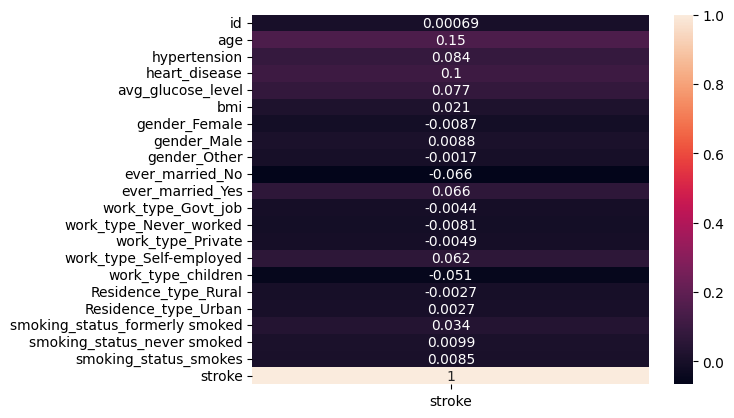

In [9]:
visualizer.corrplot(train_data, 'stroke', 'pearson')

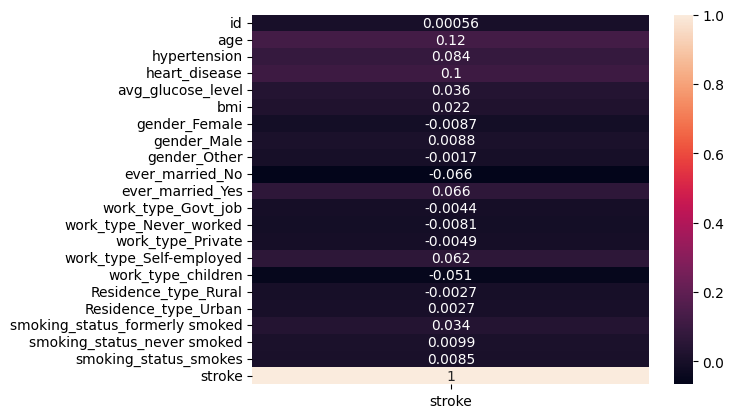

In [10]:
visualizer.corrplot(train_data, 'stroke', 'kendall')

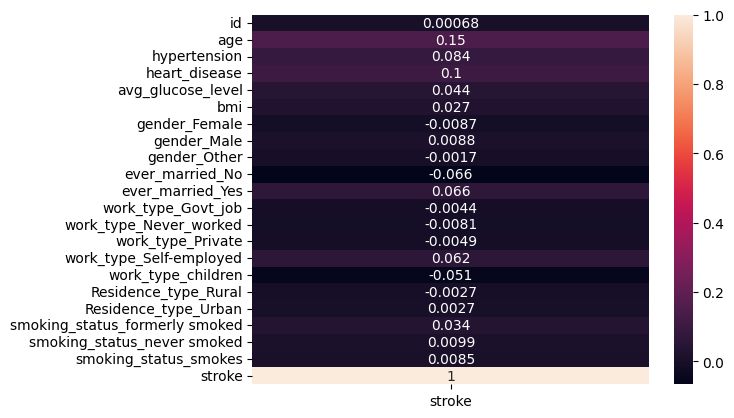

In [11]:
visualizer.corrplot(train_data, 'stroke', 'spearman')

Correlation analysis was conducted using three methods: **Pearson**, **Kendall**, and **Spearman**. The results indicate that none of these methods reveal a strong or meaningful correlation between the predictor variables and the target variable, *stroke*. This lack of correlation suggests that traditional linear relationships may be insufficient for predicting stroke occurrences within this dataset.

## 2.5 Minimum requirements for Machine Learning with Scikit Learn

- **Missing Values**: The dataset contains no missing values, ensuring data completeness—a crucial requirement for implementing machine learning algorithms using Scikit-Learn.

- **Data Types**: All columns are represented as either numeric or Boolean data types, which aligns with the input requirements for Scikit-Learn models and facilitates efficient model training.

(Boorman, n.d., DataCamp)

## 2.6 Conclusion

The exploratory data analysis reveals several important characteristics of the dataset that will inform the next steps in the machine learning pipeline:

1. **Target Variable Imbalance**: The dataset exhibits a significant class imbalance for the target variable, *stroke*, with a low number of positive cases. This imbalance may hinder model performance and requires addressing through techniques such as oversampling.

2. **Lack of Strong Correlations**: Correlation analyses using Pearson, Kendall, and Spearman methods indicate no strong relationships between predictor variables and the target variable, *stroke*. This finding suggests that non-linear models or feature engineering may be necessary to capture any underlying patterns in the data.

3. **Data Quality and Structure**: The dataset is well-prepared for machine learning applications in Scikit-Learn, with no missing values and all columns formatted as numeric or Boolean types. This readiness minimizes preprocessing requirements, allowing for a smoother transition to model building.

4. **Skewed Distributions in Glucose and BMI**: The right-skewed distributions of glucose levels and BMI highlight a potential need for transformations or normalization in preprocessing, especially if these variables prove important in downstream models.

Overall, while the dataset has many favorable qualities for machine learning, addressing the class imbalance and exploring non-linear patterns will be critical in developing a robust predictive model for stroke risk.

# 3. Data preparation 

## 3.1 Column selection

In [7]:
col_to_drop = [
    'id',
    'gender_Male',
    'gender_Other',
    'ever_married_Yes',
    'Residence_type_Urban'
]

train_data = train_data.drop(col_to_drop, axis=1)
test_data = test_data.drop(col_to_drop, axis=1)

To ensure the model's robustness and avoid issues related to multicollinearity, we removed specific columns that had direct counterparts, as these highly correlated pairs can distort the model's interpretations and predictions. The following columns were dropped:

- `gender_Male`
- `gender_Other`
- `ever_married_Yes`
- `Residence_type_Urban`

These variables were excluded to reduce redundancy and minimize multicollinearity, which can arise when features are linearly dependent or highly correlated with one another.

Additionally, the `id` column was removed as it has no theoretical or statistical relevance in predicting stroke occurrences. Since this identifier does not contribute meaningful information to the model, retaining it could lead to unnecessary noise in the dataset. (Riswanto, 2024)


## 3.2 Remove outliers

In [8]:
preprocessor = DataPreprocessor()

In [ ]:
train_data[['bmi', 'avg_glucose_level']] = preprocessor.scale_features(
    train_data, 
    ['bmi', 'avg_glucose_level']
)

train_data = train_data[
    (train_data['bmi'] < 3) & 
    (train_data['avg_glucose_level'] < 3)
]

The distributions of average glucose levels and Body Mass Index (BMI) exhibit extreme right skewness. To enhance the integrity of our analysis and ensure that our model's performance is not adversely affected by these outliers, we will implement a Z-score method for outlier detection.

Specifically, we will calculate the Z-scores for both average glucose and BMI values, and any data points with a Z-score exceeding 3 will be considered outliers and subsequently removed from the dataset (Andrade, 2021, p. 556). This approach will help in achieving a more normal distribution, thereby improving the overall robustness of our statistical analyses.


## 3.3 Feature selection

Following the evaluation of all models, we conducted an analysis to determine the importance of each feature in predicting the target variable. The results of this analysis are summarized in the table below:

![Feature Importance Table](Figures/output_table_1.png)

Based on these findings, we established a threshold for feature importance. Specifically, we opted to remove all features that exhibited a mean feature importance score below 0.05. This decision was made to enhance model interpretability and focus on the most impactful variables for our analysis.

In [8]:
cols_to_drop = [
    'Residence_type_Rural',
    'gender_Female',
    'bmi',
    'smoking_status_formerly smoked',
    'work_type_Private',
    'work_type_Never_worked',
    'smoking_status_never smoked',
    'work_type_Govt_job'
]

train_data = train_data.drop(cols_to_drop, axis=1)
test_data = test_data.drop(cols_to_drop, axis=1)

## 3.4 Creating X and y

In [9]:
X_train = train_data.drop('stroke', axis=1)
y_train = train_data['stroke']

## 3.5 Data sampling

In [10]:
y_train.value_counts()

0    32151
1      478
Name: stroke, dtype: int64

In [21]:
#rus = RandomUnderSampler()
#
#X_train, y_train = rus.fit_resample(X_train, y_train)

In [22]:
#iht = InstanceHardnessThreshold()
#
#X_train, y_train = iht.fit_resample(X_train, y_train)

In [ ]:
#smote = SMOTE()
#
#X_train, y_train = smote.fit_resample(X_train, y_train)

In [24]:
y_train.value_counts()

0    31269
1      441
Name: stroke, dtype: int64

The following three methods are available for sampling the dataset to address class imbalance. Currently, all methods are commented out; depending on the specific analysis or model run, the desired method can be uncommented. If none are uncommented, it indicates that no data sampling has been performed. The methods implemented are as follows:

- **Random Undersampler**: This technique balances the target variable by reducing the number of instances in the majority class to match the minority class. While this method effectively addresses imbalance, it can lead to the loss of potentially valuable data.

- **Instance Hardness Threshold**: This method identifies and focuses on instances that are challenging to classify. By evaluating the difficulty of each instance, it selects samples that may contribute more significantly to the model's learning process.

- **SMOTE (Synthetic Minority Over-sampling Technique)**: SMOTE generates synthetic instances of the minority class by employing a K-nearest neighbors (KNN) algorithm. This method increases the representation of the minority class without simply duplicating existing instances, thereby introducing variability into the dataset.

The choice of sampling method can significantly impact model performance and should be selected based on the specific characteristics of the dataset and the goals of the analysis.

## 3.6 Standardizing data

Columns containing float-type data will be standardized using Scikit Learn's `StandardScaler`. Standardization is a critical preprocessing step as it ensures that features with larger scales do not disproportionately influence the model's performance. 

The `StandardScaler` operates by transforming the data based on the mean and standard deviation of each feature. Specifically, it computes the Z-score for each data point, which is given by the formula:

$$
Z = \frac{(X - \mu)}{\sigma}
$$

where \(X\) is the original value, $(\mu)$ is the mean of the feature, and $(\sigma)$ is the standard deviation. This transformation rescales the data to have a mean of 0 and a standard deviation of 1, thereby facilitating a more uniform and interpretable dataset for subsequent analysis and modeling.


In [12]:
X_train[['age', 'avg_glucose_level']] = preprocessor.scale_features(
    X_train, 
    ['age', 'avg_glucose_level']
)

test_data[['age', 'avg_glucose_level']] = preprocessor.scale_features(
    test_data, 
    ['age', 'avg_glucose_level']
)

# 4. Evaluation metrics

## Possible Metrics

For classification tasks like predicting strokes, there are four different total metrics to evaluate model performance. 

Accuracy: The ratio of correctly predicted instances to the total instances.

Precision: The ratio of true positives to the sum of true positives and false positives, indicating how many of the positive predictions were correct.

Recall: The ratio of true positives to the sum of true positives and false negatives, showing how well the model identifies all positive instances.

F1 Score: The harmonic mean of precision and recall, providing a balance between these two metrics.

### Confusion matrix 

To give a more concrete example using a small confusion matrix:

|                   | Predicted "Stroke" | Predicted "No Stroke" |
|-------------------|------------------|---------------------|
| **Actual "Stroke"** | 50               | 5                  |
| **Actual "No Stroke"** | 10           | 135                |


**Accuracy** = (TP + TN) / (TP + TN + FP + FN)

-> (50 + 135) / (50+10+5+135) = 0.925 = 92.5%

**Precision** = TP / (TP + FP)

-> (50) / (50+10) = 0.8333 = 83.33%

**Recall** = TP / (TP + FN)

-> (50) / (50+5) = 0.909 = 90.9%

**F1 Score** = 2 * (Precision * Recall) / (Precision + Recall)

2 * (0.909*0.8333)/(0.8333 + 0.909) = 0.8696 = 86.96
(Boorman, n.d., DataCamp)


## Example metrics-calcuation using a simple KNN-model

In [17]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("Accuracy on Training Set:", accuracy_train)
print("Precision on Training Set:", precision_train)
print("Recall on Training Set:", recall_train)
print("F1 Score on Training Set:", f1_train)

Accuracy on Training Set: 0.920406830269665
Precision on Training Set: 0.8883047487718694
Recall on Training Set: 0.961743025100308
F1 Score on Training Set: 0.9235663082437277


## Why F1 for evaluation in this scenario?

In our dataset, there is an imbalance regarding the target variable. Strokes do not happen too often and therefore, in the dataset there will be a lot more entries where the feature "stroke" is zero. F1 does a better job at handling such imbalances than accuracy for example. The F1-score is the harmonic mean of precision and recall and therefore takes into account false negatives as well as false positives into consideration. Hence, it can give a more balanced and general view of the actual performance. 

This is especially important since a medical diagnosis like a stroke diagnosis must be as precise as possible and errors must be minimized. A false negative prediction is nothing less than life-threatening and false positives would unnecessarily burden patients and healthcare system. Relying on accuracy for example, would lead to more false negatives and is therefore not a evaluation method worth considering. 

Using the F1-score allows the model to optimized to be accurate but also reliable. Using accuracy as the metric would lead to higher accuracy scores but it would be far less reliable - especially in medical contexts. (Araf, Idri, & Chairi, 2024, p. 51)


# 5. Models

## 5.1 K-Nearest Neighbours

### 5.1.1 Hyperparameter tuning

In [499]:
knn = KNeighborsClassifier(weights='uniform', algorithm='ball_tree')

param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5],
    'p': [1, 2, 3, 4, 5]
}

knn_cv = GridSearchCV(
    estimator=knn, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)


### 5.1.2 Training KNN

In [500]:
knn_cv.fit(X_train, y_train)

print("Best parameters:", knn_cv.best_params_)
print("Best cross-validation score:", knn_cv.best_score_)

knn_vc = knn_cv.best_estimator_

Best parameters:  {'n_neighbors': 1, 'p': 3}
Best cross-validation score:  0.36631762286820974


### 5.1.3 Predicting KNN

In [501]:
knn_pred = knn_cv.predict(test_data)

knn_pred_df = test_data_ids.to_frame()
knn_pred_df['stroke'] = knn_pred

### 5.1.4 Writing to CSV

In [502]:
knn_pred_df.to_csv('Datasets/Predictions/knn_pred.csv', index=False)

### 5.1.5 KNN explanation

The k-Nearest Neighbors (kNN) algorithm classifies data points based on their proximity to labeled training data. It operates by plotting all data points in a multi-dimensional space, where each point is associated with a specific target variable. When a new test data point is introduced, the algorithm computes the distances to the K nearest neighbors. The distance can be calculated using various metrics, each suited for different types of data.(IBM, n.d.)


**Distance Metrics**

1. **Euclidean Distance**: This metric calculates the straight-line distance between two points in Euclidean space. It is defined as:
   $$
   d(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
   $$
   where $(\mathbf{p})$ and $(\mathbf{q})$ are the coordinates of the two points.

2. **Manhattan Distance**: Also known as the L1 distance, this metric measures the sum of the absolute differences of their Cartesian coordinates. It can be interpreted as the distance one would travel along axes in a grid-like path:
   $$
   d(\mathbf{p}, \mathbf{q}) = \sum_{i=1}^{n} \|p_i - q_i\|
   $$


**Prediction Methods**

Once the distances to the K nearest neighbors are computed, the algorithm can make predictions using one of two methods:

1. **Majority Voting**: The predicted class for the test data point is determined by the class that occurs most frequently among the K nearest neighbors.

2. **Mean Distance Calculation**: Alternatively, the algorithm can calculate the mean distance per class. The class with the smallest mean distance to the test point is selected as the predicted class.

These methodologies ensure that the kNN algorithm provides a flexible and robust classification mechanism for various types of datasets.


**Importance of standardization**

The KNN-model uses distance to predict new values. This is fine as long as all values in the dataset have similiar scales. If they dont, features with higher scales will always overshadow smaller-scaled features. A good example for this would be Body-Height versus Body-Weight. Are person can easily weigh 100kgs, but is not bigger than 2 metres. Without standardization, the distance metric would be skewed and the predictions would be heavily influenced by certain features. 

Therefore, standardization leads to higher accuracy and prevents bias.

**Regularization in K-Nearest Neighbors (KNN)**

In machine learning, **regularization** is typically used to prevent overfitting by adding a penalty to complex models. However, for non-parametric models like K-Nearest Neighbors (KNN), the regularization approach differs, as KNN does not fit a parametric function but instead makes predictions based on the proximity of the data points in the feature space. In KNN, regularization is not explicitly applied in the same way as in parametric models (e.g., ridge or lasso in linear models), but certain parameters inherently act as regularizers to control model complexity and improve generalization.  (DataCamp, n.d.).

**Key Regularization Aspects in KNN**
1. **Choice of K (Number of Neighbors):**
   - The value of $K$ plays a crucial role in controlling the **bias-variance trade-off** in the KNN model. A lower $K$ value makes the model sensitive to noise, as it focuses on fewer neighbors, leading to high variance and potential overfitting. Conversely, a higher $K$ value smoothens the decision boundary, reducing variance but increasing bias, which can prevent overfitting to training data.
   - Selecting an optimal $K$ value thus indirectly acts as a regularization technique, with lower values favoring high complexity and higher values enforcing smoother, generalized decision boundaries.

2. **Distance Metric:**
   - The **distance metric** used (e.g., Euclidean, Manhattan) also affects the regularization of KNN. Different metrics can emphasize different aspects of the data, and selecting an appropriate metric can impact how sensitive the model is to feature scaling and outliers, indirectly influencing regularization.
   - Additionally, weighting the distance metric (such as inverse distance weighting) allows more control over the influence of neighbors, which can be seen as a form of regularization, reducing over-reliance on nearest neighbors alone.

**Regularization by Cross-Validation**
- **Cross-validation** can be used in conjunction with the choice of $K$ to find an optimal balance, which effectively acts as a regularization process by tuning $K$ to minimize overfitting while maintaining good predictive performance. (DataCamp, n.d.).

In summary, while KNN lacks explicit regularization terms like those in parametric models, the selection of $K$, distance metric, feature scaling, and the use of cross-validation all contribute to the regularization of the KNN model, controlling complexity and improving generalization performance.

## 5.2 Logistic Regression

### 5.2.1 Hyperparameter tuning

In [503]:
lr = LogisticRegression(penalty='l1', solver='liblinear')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0],
    'max_iter': [50, 60, 70, 80, 90, 100]
}

lr_cv = GridSearchCV(
    estimator=lr, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

### 5.2.2 Training LR

In [505]:
lr_cv.fit(X_train, y_train)

print("Best parameters:", lr_cv.best_params_)
print("Best cross-validation score:", lr_cv.best_score_)

lr_vc = lr_cv.best_estimator_

Best parameters:  {'C': 1.0, 'max_iter': 50}
Best cross-validation score:  0.12355677767807416


### 5.2.3 Predicting LR

In [507]:
lr_pred = lr_cv.predict(test_data)

lr_pred_df = test_data_ids.to_frame()
lr_pred_df['stroke'] = lr_pred

### 5.2.4 Writing to CSV

In [508]:
lr_pred_df.to_csv('Datasets/Predictions/lr_pred.csv', index=False)

### 5.2.5 LR explanation

Logistic Regression is a widely-used linear model for binary classification tasks. It models the probability that a given instance belongs to the positive class (e.g., stroke) using a logistic function. In this analysis, we will optimize the regularization parameter \(C\) and explore different solvers to identify the best-performing model (Jurafsky & Martin, 2024).

**Mathematical Foundation**

The Logistic Regression model can be expressed mathematically as follows:

$$
\ln\left(\frac{P}{1 - P}\right) = \beta_{0} + \beta_{1} \cdot x \implies P = \frac{e^{\beta_{0} + \beta_{1} \cdot x}}{1 + e^{\beta_{0} + \beta_{1} \cdot x}}
$$

Where:
- $(P(y=1|x))$: The probability of the target variable being 1 given the input features \(X\).
- $(\beta_{0}, \beta_{1})$: Coefficients to be learned from the training data.
- $(x)$: Input feature.

**Loss Function: Binary Cross-Entropy / Log Loss**

To evaluate model performance, we employ a loss function aimed at minimizing the difference between predicted and actual values. The binary cross-entropy (log loss) can be defined as:

$$
H_{p}(q) = -\frac{1}{N} \sum_{i=1}^{N} \left( y_{i} \log{p(y_{i})} + (1 - y_{i}) \log{(1 - p(y_{i}))} \right)
$$

Where:
- $(y)$: Target label (1 for stroke, 0 for no stroke).
- $(p(y))$: Predicted probability of stroke for all $(N)$ instances.

This formulation indicates that for instances where a stroke occurs $((y=1))$, the loss increases with $(\log{p(y)})$, representing the log-probability of a stroke. Conversely, for instances without a stroke $((y=0))$, the term $(\log{1-p(y)})$ contributes to the loss.

**Optimization: Gradient Descent**

Gradient Descent is an optimization algorithm used in Logistic Regression (and other models) to determine the optimal parameters (weights) that minimize the model's error. The update rule for the weights is defined as:

$$
\theta = \theta - \alpha \cdot \nabla J(\theta)
$$

Where:
- $(\theta)$: Current weight values.
- $(\alpha)$: Learning rate, which controls the step size.
- $(\nabla J(\theta))$: Gradient of the loss function with respect to $(\theta)$.

**Regularization in Logistic Regression**

Regularization techniques are employed to mitigate overfitting, which occurs when a model learns the training data too closely, resulting in poor performance on new data. Regularization introduces a penalty to the loss function, discouraging the use of excessively large coefficients.

*Types of Regularization*

1. **L1 Regularization (Lasso)**:
   - Encourages sparsity in the model by driving some coefficients to zero, thus performing feature selection.

2. **L2 Regularization (Ridge)**:
   - Penalizes the squared values of coefficients, discouraging large coefficients and reducing model sensitivity to small changes in the input data.

3. **ElasticNet**:
   - Combines L1 and L2 regularization, leveraging the benefits of both approaches for improved model robustness.

**Regularization and Overfitting**

Overfitting occurs when a model captures noise in the training data, impairing its performance on unseen data. Regularization counteracts this by penalizing large coefficients, resulting in a simpler and more generalizable model. 

*Effect of Regularization*

- **Without Regularization**: The model may exhibit large coefficients, leading to high variance and overfitting.
- **With Regularization**: Coefficient values are constrained, thereby reducing the risk of overfitting and enhancing the model's capacity to generalize to new data.

By implementing these concepts, we can enhance the performance and reliability of our Logistic Regression model for binary classification tasks.


## 5.3 SVM

### 5.3.1 Hyperparameter tuning

In [509]:
svc = SVC(probability=True, degree=2, max_iter=400)

param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 1, 2, 3, 4, 5],
    'C': [0.001, 0.01, 0.1, 1.0]
}

svc_cv = GridSearchCV(
    estimator=svc, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

### 5.3.2 Training SVC

In [511]:
svc_cv.fit(X_train, y_train)

print("Best parameters:", svc_cv.best_params_)
print("Best cross-validation score:", svc_cv.best_score_)

svc_vc = svc_cv.best_estimator_

Best parameters:  {'C': 0.1, 'gamma': 3, 'kernel': 'rbf'}
Best cross-validation score:  0.27489290774783126


### 5.3.3 Predicting SVC

In [513]:
svc_pred = svc_cv.predict(test_data)

svc_pred_df = test_data_ids.to_frame()
svc_pred_df['stroke'] = svc_pred

### 5.3.4 Writing to CSV

In [514]:
svc_pred_df.to_csv('Datasets/Predictions/svc_pred.csv', index=False)

### 5.3.5 SCV explanation

Support Vector Machines (SVM) are supervised learning models used for classification and regression tasks. The primary objective of SVM is to separate data points into distinct classes using a hyperplane while maximizing the margin between the classes. The hyperplane serves as the decision boundary that distinguishes the different groups. The margin is defined as the distance between the hyperplane and the nearest data points from each class, which are referred to as support vectors.

**Mathematical Foundations & Example**

*Objective Function*

$$
\min_{\mathbf{w},\ b} \quad \frac{1}{2} \|\mathbf{w}\|^2
$$

*Constraints*

$$
y_i (\mathbf{w}^\top \mathbf{x}_i + b) \geq 1, \quad \text{for } i = 1, 2, \dots, n
$$

- **Weight Vector:**

  $$
  \mathbf{w} \in \mathbb{R}^d
  $$

  - $\mathbf{w}$: A vector of weights, where $d$ is the number of features.

- **Bias Term:**

  $$
  b \in \mathbb{R}
  $$

  - $b$: The bias or intercept term.

- **Class Labels:**

  $$
  y_i \in \{ -1, +1 \}
  $$

  - $y_i$: The label for the $i$-th training example, indicating the class.

- **Feature Vectors:**

  $$
  \mathbf{x}_i \in \mathbb{R}^d
  $$

  - $\mathbf{x}_i$: The feature vector for the \( i \)-th training example.

*Decision Function*

$$
f(\mathbf{x}) = \text{sign}(\mathbf{w}^\top \mathbf{x} + b)
$$

- **Classification Rule:**

  - If $f(\mathbf{x}) = +1$, classify $\mathbf{x}$ as the **positive class**.
  - If $f(\mathbf{x}) = -1$, classify $\mathbf{x}$ as the **negative class**.

*Margin Width*

$$
\text{Margin} = \frac{2}{\|\mathbf{w}\|}
$$

**Explaining SVM using a small subset of our data**

| ID | Age | Stroke |
|----------|----------|----------|
| 1   | 50   | -1   |
| 2    | 55   | -1   |
| 3    | 65   | 1  |
| 4    |70   | 1  |


1. $-1(\mathbf{w}*50 +b) >=1$

2. $-1(\mathbf{w}*55 +b) >=1$

3. $(\mathbf{w}*65 +b) >=1$

4. $(\mathbf{w}*70 +b) >=1$

Solve for $\mathbf{w}$ and b using line 2. and 3. 

$-1(\mathbf{w}*55 +b) >=1$

$(\mathbf{w}*65 +b) >=1$

$(-55 \mathbf{w} -b) + (65 \mathbf{w} +b ) > 1 +1 ->  10 \mathbf{w} >=2 -> w>=0.2$

now that we know $\mathbf{w}$, we can find b:

$-1(\mathbf{w}*55 +b) >=1 -> -55*0.2 -b >=1 -> -11 -b >=1 -> -b = 12 -> b=-12$

$(\mathbf{w}*65 +b) >=1 -> 65*0.2 +b >=1 -> 13 + b >=1 -> b = -12$

$b=-12$

*Decision Boundary*

$(\mathbf{w})*x + b -> 0.2x - 12 = 0$

Decision Boundary: $x=12/0.2 -> x=60$

*Testing against the constraints*

$-1(\mathbf{w}*50 +b) >=1 -> -1(0.2x50 - 12) >=1 -> 2 >=1 (True)$

$-1(\mathbf{w}*55 +b) >=1 -> -1(0.2x55 - 12) >=1 -> 1 >=1 (True)$

$(\mathbf{w}*65 +b) >=1   -> (0.2x65 - 12) >=1   -> 1 >=1 (True)$

$(\mathbf{w}*70 +b) >=1   -> (0.2x70 - 12) >=1   -> 2 >=1 (True)$

*Interpretation*

Our small example model would suggest that if the age is below 60, there is no stroke. However, if the person is over 60, there is a stroke.

**Kernel Functions and the Kernel Trick**

In the context of machine learning, a kernel function quantifies the similarity between two data points. Kernel functions are instrumental in capturing complex patterns and managing non-linear relationships by mapping the input data into higher-dimensional spaces. When a linear hyperplane cannot adequately separate data points due to their distribution, the kernel trick can be applied. This technique transforms the data into a higher-dimensional space (e.g., from 2D to 3D), facilitating better separation of the classes.

**Regularization in SVM**

Regularization is crucial for preventing overfitting in machine learning models, including SVMs. There are several types of regularization techniques applied within SVM:

- **L1 Regularization**: This approach aims at feature selection by reducing the weights of less important features to zero, resulting in a more parsimonious model. However, L1 regularization may inadvertently remove important features, particularly in datasets with multiple equally significant features, which can lead to model instability. It is especially prone to instability when the number of features exceeds the number of samples.

- **L2 Regularization**: This technique encourages larger margins between classes, thereby enhancing the model's ability to generalize to new data and reducing overfitting. L2 regularization penalizes the square of the weights (i.e., large coefficients are heavily penalized) but does not eliminate any features from the model, allowing all features to remain.

- **C Parameter Regularization**: The C parameter in SVM controls the trade-off between strict classification of all data points and allowing for some misclassification to achieve a more generalized decision boundary. A higher C value increases the risk of overfitting, as it forces the model to classify every point correctly, while a lower C value intentionally permits misclassifications to promote generalization.


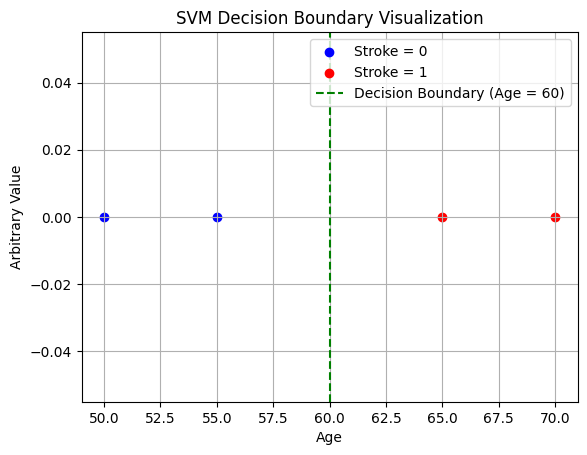

In [ ]:
ages_negStroke = [50, 55]
ages_posStroke = [65, 70]
y_neg = [0, 0] 
y_pos = [0, 0]

plt.scatter(ages_negStroke, y_neg, color='blue', label='Stroke = 0')

plt.scatter(ages_posStroke, y_pos, color='red', label='Stroke = 1')

plt.axvline(x=60, color='green', linestyle='--', label='Decision Boundary (Age = 60)')

plt.xlabel('Age')
plt.ylabel('Arbitrary Value')
plt.title('SVM Decision Boundary Visualization')
plt.legend()
plt.grid(True)
plt.show()


## 5.4 Decision Tree

### 5.4.1 Hyperparameter tuning

In [515]:
dt = DecisionTreeClassifier(criterion='entropy', max_features='log2')

param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10]
}

dt_cv = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

### 5.4.2 Training DT

In [516]:
dt_cv.fit(X_train, y_train)

print("Best parameters:", dt_cv.best_params_)
print("Best cross-validation score:", dt_cv.best_score_)

dt_vc = dt_cv.best_estimator_

Best parameters:  {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 9}
Best cross-validation score:  0.3093676376596971


### 5.4.3 Predicting DT

In [517]:
dt_pred = dt_cv.predict(test_data)

dt_pred_df = test_data_ids.to_frame()
dt_pred_df['stroke'] = dt_pred

### 5.4.4 Writing to CSV

In [518]:
dt_pred_df.to_csv('Datasets/Predictions/dt_pred.csv', index=False)

### 5.4.5 DT explanation

A Decision Tree is a non-parametric model used for both classification and regression tasks (Kawerk, n.d., "Decision-Tree for Classification"). It makes predictions by recursively partitioning the data into smaller subsets based on feature values. Each internal node in the tree corresponds to a decision made based on a specific feature, while each leaf node represents a predicted outcome or class.

**Splitting Criteria**

The effectiveness of a Decision Tree hinges on the criteria used to determine the best splits. The two most prevalent criteria are:

1. **Gini Impurity**:  
   Gini Impurity quantifies the likelihood of mislabeling a randomly selected element from the dataset if it were classified according to the class distribution at the node. A lower Gini Impurity value indicates a purer node.

2. **Entropy (Information Gain)**:  
   Entropy measures the level of impurity in a node, with the objective of maximizing **Information Gain**, which is the difference in entropy before and after the split. This process aims to create purer nodes.

(Kawerk, n.d., "Classification-Tree Learning")

**Pruning and Overfitting**

**Pruning** is a critical technique used to simplify the Decision Tree model by removing sections of the tree that do not contribute significantly to predictive power. This practice helps mitigate the risk of overfitting. Pruning can be categorized into two primary forms:

1. **Pre-Pruning (Early Stopping)**:  
   Pre-pruning involves halting the growth of the tree before it reaches its maximum depth. This can be achieved by imposing constraints such as limiting the depth of the tree, setting a minimum number of samples required to perform a split, or requiring a minimum number of samples at a leaf node. These measures prevent the model from becoming overly complex (GeeksforGeeks, 2024).

2. **Post-Pruning**:  
   In this approach, the tree is fully grown before assessing its structure. Post-pruning entails the removal of branches that contribute minimally to the model's performance. This is accomplished by evaluating the tree's performance on validation data and eliminating branches that do not enhance generalization (GeeksforGeeks, 2024). 


*Considerations for Pruning*

While pruning is effective for reducing overfitting, it is crucial to avoid excessive pruning, as this can lead to **underfitting**. Underfitting occurs when the tree is overly simplistic and fails to capture the underlying patterns present in the data, thereby impairing predictive accuracy (Fedmug, 2022).



## 5.5 Ensembles

### 5.5.1 Random Forest

#### 5.5.1.1 Hyperparameter tuning

In [519]:
rf = RandomForestClassifier(
    max_features='log2', 
    bootstrap=True, 
    criterion='log_loss', 
    n_estimators=100
)

param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10]
}

rf_cv = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

#### 5.5.1.2 Training RF

In [520]:
rf_cv.fit(X_train, y_train)

print("Best parameters:", rf_cv.best_params_)
print("Best cross-validation score:", rf_cv.best_score_)

rf_vc = rf_cv.best_estimator_

Best parameters:  {'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 4}
Best cross-validation score:  0.25054719494697303


#### 5.5.1.3 Predicting RF

In [521]:
rf_pred = rf_cv.predict(test_data)

rf_pred_df = test_data_ids.to_frame()
rf_pred_df['stroke'] = rf_pred

#### 5.5.1.4 Writing to CSV

In [522]:
rf_pred_df.to_csv('Datasets/Predictions/rf_pred.csv', index=False)

#### 5.5.1.5 RF explanation

Random Forest (RF) is an ensemble learning technique that constructs multiple decision trees and aggregates their individual predictions to create a more robust model, often referred to as a "forest." The primary method employed to build each decision tree in a Random Forest is known as **bagging** (Bootstrap Aggregating) (Kawerk, n.d., "Random Forests (RF)").

**Bagging Process**

In the context of a Random Forest, bagging involves training each decision tree independently using a random sample of the training dataset. This sampling is done with replacement, allowing some observations to be included multiple times while others may be excluded (Kawerk, n.d., "Bagging"). 

*Feature Randomization*

In addition to random sampling of the data, Random Forest enhances the diversity of the individual trees by randomly selecting a subset of features to consider at each split in the decision tree. This randomness in feature selection helps to reduce correlation among the trees, thereby improving the overall accuracy and generalization of the model.

The combination of bagging and feature randomization makes Random Forest a powerful and versatile machine learning algorithm, capable of effectively handling large datasets and complex interactions between features (Kawerk, n.d., "Random Forests (RF)").

**Training time**

The training time for a RF is rather short since multiple trees can be trained at the same time (parallel) (Kawerk, n.d., "Random Forests (RF)").

### 5.5.2 Gradient Boosting Classifier

#### 5.5.2.1 Hyperparameter tuning

In [523]:
gb = GradientBoostingClassifier(
    criterion='friedman_mse', 
    loss='log_loss', 
    max_features='log2', 
    n_estimators=100
)

param_grid = {
    'max_depth': [8, 9, 10, 11, 12, 13],
    'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10]
}

gb_cv = GridSearchCV(
    estimator=gb, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

#### 5.5.2.2 Training GB

In [524]:
gb_cv.fit(X_train, y_train)

print("Best parameters:", gb_cv.best_params_)
print("Best cross-validation score:", gb_cv.best_score_)

gb_vc = gb_cv.best_estimator_

Best parameters:  {'max_depth': 13, 'min_samples_leaf': 5, 'min_samples_split': 5}
Best cross-validation score:  0.40495272867535775


#### 5.5.2.3 Predicting GB

In [525]:
gb_pred = gb_cv.predict(test_data)

gb_pred_df = test_data_ids.to_frame()
gb_pred_df['stroke'] = gb_pred

#### 5.5.2.4 Writing to CSV

In [526]:
gb_pred_df.to_csv('Datasets/Predictions/gb_pred.csv', index=False)

#### 5.5.2.5 GB explanation

Gradient Boosting, often referred to as GBoost, operates on principles similar to those of Random Forests (RF) in that both models construct decision trees to enhance predictive performance. However, the fundamental distinction lies in the ensemble techniques employed to build these trees (Kawerk, n.d., "Gradient Boosting (GB)"). 

**Ensemble Techniques**

- **Random Forest (RF)**: Utilizes **bagging** (Bootstrap Aggregating) to create its ensemble of trees. In this approach, each tree is trained independently on a random subset of the training data (Kawerk, n.d., "Random Forests (RF)").

- **Gradient Boosting (GBoost)**: Employs a technique known as **boosting**. In this context, boosting refers to the iterative process where each new tree is trained to correct the residual errors (the difference between the predicted and actual values) of all preceding trees. This method aims to systematically improve the overall accuracy of the model by combining the predictions from each tree (Kawerk, n.d., "Gradient Boosting (GB)").

By sequentially adding trees that focus on correcting the shortcomings of the existing model, Gradient Boosting effectively enhances predictive accuracy and can handle a variety of complex data patterns (Kawerk, n.d., "Gradient Boosting (GB)").

**Training time**

The trees in a GBC are built sequentially because each newly built tree is based on the output of the prior tree. This leads to a longer training time since the process cannot be done parallel (Kawerk, n.d., "Gradient Boosting (GB)").

### 5.5.3 XGBoost

#### 5.5.3.1 Hyperparameter tuning

In [527]:
xgb = XGBClassifier(objective='binary:logistic', n_estimators=100)

param_grid = {
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.001, 0.01, 0.1, 1.0],
    'gamma': [0, 1, 2, 3, 4, 5]
}

xgb_cv = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
)

#### 5.5.3.2 Training XGB

In [528]:
xgb_cv.fit(X_train, y_train)

print("Best parameters:", xgb_cv.best_params_)
print("Best cross-validation score:", xgb_cv.best_score_)

xgb_vc = xgb_cv.best_estimator_

Best parameters:  {'gamma': 0, 'learning_rate': 1.0, 'max_depth': 4}
Best cross-validation score:  0.3590310773587727


#### 5.5.3.3 Predicting XGB

In [529]:
xgb_pred = xgb_cv.predict(test_data)

xgb_pred_df = test_data_ids.to_frame()
xgb_pred_df['stroke'] = xgb_pred

#### 5.5.3.4 Writing to CSV

In [530]:
xgb_pred_df.to_csv('Datasets/Predictions/xgb_pred.csv', index=False)

#### 5.5.3.5 XGB explanation

XGBoost (Extreme Gradient Boosting) is an optimized implementation of the Gradient Boosting (GB) framework. While it retains the core principle of boosting—where each new tree is trained to correct the errors made by its predecessors—XGBoost introduces several enhancements that improve its performance and flexibility.

**Key Improvements**

1. **Regularization**:  
   XGBoost incorporates both L1 (Lasso) and L2 (Ridge) regularization techniques, which help to reduce overfitting by penalizing the complexity of the model. This regularization can lead to better generalization on unseen data.

2. **Handling of Weighted and Missing Data**:  
   XGBoost provides robust mechanisms for managing weighted data points and effectively dealing with missing values. This capability allows the model to leverage incomplete datasets and adjust for the importance of individual observations during training.

Through these optimizations, XGBoost achieves significant improvements in computational efficiency and predictive accuracy, making it a popular choice for a wide range of machine learning applications.

**Training time**

The trees in a XGB are built sequentially because each newly built tree is based on the output of the prior tree. However, XGBoost is not strictly sequential. While it still builds each tree sequentially, the building of each individual tree is improved. The search for the best split for example is parallelized (the evualation of features is distributed over different processors). This "hybrid" attempt reduces the training time of a XGBoost model compared to a GB model.

(GeeksforGeeks, 2023)



### 5.5.4 Self assembled ensemble (voting classifier)

#### 5.5.4.1 Hard voting classifier

##### 5.5.4.1.1 Instantiating voting classifier

In [531]:
estimators = [
    ('knn', knn_vc), 
    ('lr', lr_vc), 
    ('svc', svc_vc), 
    ('dt', dt_vc), 
    ('rf', rf_vc), 
    ('gb', gb_vc), 
    ('xgb', xgb_vc)
]

vc_hard = VotingClassifier(estimators=estimators, voting='hard')

##### 5.5.4.1.2 Training VC_Hard

In [532]:
vc_hard.fit(X_train, y_train)

mean_score = cross_val_score(
    vc_hard, 
    X_train, 
    y_train, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
).mean()

0.2924801849192789

##### 5.5.4.1.3 Predicting VC_Hard

In [533]:
vc_hard_pred = vc_hard.predict(test_data)

vc_hard_pred_df = test_data_ids.to_frame()
vc_hard_pred_df['stroke'] = vc_hard_pred

##### 5.5.4.1.4 Writing to CSV

In [534]:
vc_hard_pred_df.to_csv('Datasets/Predictions/vc_hard_pred.csv', index=False)

##### 5.5.4.1.5 VC_Hard explanation

A **voting classifier** is an ensemble learning method used to improve the performance of machine learning models by aggregating predictions from multiple models. By combining multiple individual models, the voting classifier aims to produce a more robust and accurate prediction than any single model alone.

This ensemble method leverages the principle of "wisdom of the crowd," where each model in the ensemble votes for a particular class, and the final decision is based on an aggregation method. The two primary voting methods are **hard voting** and **soft voting**:

1. **Hard Voting**: Each model contributes one vote for its predicted class. The class with the majority of votes becomes the final prediction.
2. **Soft Voting**: Each model provides the probability of each class, and the class with the highest average probability is selected as the final prediction.

**Hard Voting Classifier**

In a **hard voting classifier**, the final prediction, denoted $y_{\text{pred}}$, is determined by the majority vote among the individual models’ predictions. This means that each model contributes a discrete vote, and the class with the most votes is selected as the final output.

Mathematically, the hard voting classifier can be represented as:

$$
y_{pred} = mode\{ pred_{1}, pred_{2}, \dots, pred_{N} \}
$$

where:
- $mode$ denotes the most frequently occurring prediction (the majority vote),
- $N$ represents the total number of models in the ensemble,
- $pred_{i}$ is the prediction made by model $i$,
- $y_{pred}$ is the final prediction produced by the voting classifier.

**Special Case: Ties**

In scenarios where there is a tie in the voting process (e.g., an equal number of votes for two classes), different strategies may be used to resolve the tie. Common approaches include:
- **Random Tie-Breaking**: Selecting a class at random from the tied classes.
- **Weighted Voting**: Assigning weights to models based on their confidence or accuracy, if available.
- **Prior Probabilities**: Selecting based on prior knowledge of class distributions, if known.

The hard voting classifier is often beneficial when using a diverse set of models, as each model can bring a different perspective, reducing the likelihood of overfitting and potentially improving generalization.



#### 5.5.4.2 Soft voting classifier

##### 5.5.4.2.1 Instantiating voting classifier

In [535]:
estimators = [
    ('knn', knn_vc), 
    ('lr', lr_vc), 
    ('svc', svc_vc), 
    ('dt', dt_vc), 
    ('rf', rf_vc), 
    ('gb', gb_vc), 
    ('xgb', xgb_vc)
]

vc_soft = VotingClassifier(estimators=estimators, voting='soft')

##### 5.5.4.2.2 Training VC_Soft

In [536]:
vc_soft.fit(X_train, y_train)

mean_score_soft = cross_val_score(
    vc_soft, 
    X_train, 
    y_train, 
    cv=10, 
    scoring='f1', 
    n_jobs=-1
).mean()

0.3894622441200358

##### 5.5.4.2.3 Predicting VC_Soft

In [537]:
vc_soft_pred = vc_soft.predict(test_data)

vc_soft_pred_df = test_data_ids.to_frame()
vc_soft_pred_df['stroke'] = vc_soft_pred

##### 5.5.4.2.4 Writing to CSV

In [538]:
vc_soft_pred_df.to_csv('Datasets/Predictions/vc_soft_pred.csv', index=False)

##### 5.5.4.2.5 VC_Soft explanation

A **voting classifier** is an ensemble learning method that aggregates predictions from multiple models to achieve a more robust and accurate result. Each model within the ensemble makes a prediction, and the final decision is based on a specified voting method: **soft voting** or **hard voting**.

**Soft Voting Classifier**

The **soft voting classifier** determines its prediction based on the average of predicted probabilities from each model. This method weighs each model's confidence in its prediction, rather than simply counting votes as in hard voting. In general, soft voting is preferred when probability estimates are well-calibrated across models.

The prediction $y_{pred}$ is calculated as follows:

$$
y_{pred} = \sum_{i=1}^{N} \frac{pred_{i}}{N}
$$

where:
- $i$ denotes each individual model in the ensemble,
- $N$ represents the total number of models,
- $pred_{i}$ is the probability prediction made by model $i$,
- $y_{pred}$ is the final averaged prediction made by the voting classifier.

This approach can yield superior results by leveraging the diversity of predictions from different models, thus improving the robustness and generalization of the ensemble.

## 6. Deciding feature importances

In [539]:
# lr_fi = lr_cv.best_estimator_.coef_
# dt_fi = dt_cv.best_estimator_.feature_importances_
# rf_fi = rf_cv.best_estimator_.feature_importances_
# gb_fi = gb_cv.best_estimator_.feature_importances_

# fi_df = pd.DataFrame({
#     'Features': X_train.columns, 
#     'LR': lr_fi[0], 
#     'DT': dt_fi, 
#     'RF': rf_fi, 
#     'GB': gb_fi
# })
# fi_df['LR'] = np.abs(fi_df['LR'])
# fi_df['mean'] = fi_df.mean(axis=1)

# fi_df = fi_df.sort_values(by='mean', ascending=False)

# fig, ax = plt.subplots(figsize=(20, 6))
# ax.axis('tight')
# ax.axis('off')
# ax.table(cellText=fi_df.values, colLabels=fi_df.columns, cellLoc='center', loc='center')

# ax.set_title("Feature Importance Table (Run 1 with all features)", fontsize=16, fontweight='bold')

# plt.savefig('Figures/output_table_2.png', format='png')

# plt.show()

# Conclusion and Advice

## 1. Overview - Model performance

The following will give an overview over model performance.

### 1.1 Best Performing Model
The model that performed the best across all attempts is **Gradient Boosting (GB)** from **Attempt 10** with a Kaggle score of **0.16438**. This can be seen in our Github Repository (https://github.com/Primestyler/Machine-Learning-Group). Alternatively, the table can also be found in our README.md in our project. It gives a precise overview of the number of attempts, the model used, the hyperparamters, the F1-score in our notebook and Kaggle-score. Additionally, the method of sampling is provided giving an even more accurate depiction of our models and their performances. 

#### Best Model Hyperparameters:
- `max_depth`: 10
- `min_samples_leaf`: 2
- `min_samples_split`: 6
- `n_estimators`: 100

This setup achieved the highest Kaggle score, suggesting that this model configuration effectively handled the complexities of the dataset.

---

### 1.2 Analysis of Sampling Methods and Model Performance
- Models that used **Instant Hardness Threshold (IHT)** generally achieved the highest Kaggle scores compared to other sampling techniques.
- **Gradient Boosting** and **XGBoost** particularly benefited from IHT, as it likely helped these models manage difficult-to-classify samples by focusing on instances where classification was most challenging.
- IHT appears to have effectively addressed class imbalance, allowing the models to perform well on the test set.

## 2. Other considerations than performance

While performance is an important indicator, in real world applications it is not the only thing that matters.

1. Computation Efficiency

In real world scenarios, models which require less computing power and are faster at making predictions, might be a better fit than models that are only optimized on performance (Pernkopf et al., 2018). 

2. Understandable predictions/explanations

Especially in medical contexts, models need to be understandable and even more important their predictions need to be explainable. A model with really good performance that makes predictions that are really difficult to understand and to interpret, is surely not optimal. On the side, the patient must be able to trust the predictions made by the AI and "black box"-like predictions make the model not seem trustworthy. On the other side, the medical personal must be able to understand what the model does (at least to some extend) in order to make informed decisions and work together with the model properly (Doshi-Velez & Kim, 2017). 

3. Scalability

The model should be able to handle the growing amount of data gained in the healthcare sector. If it fails at that, the models performance might be good in a research enviroment but will decrease in real world settings (Archetti et al., 2023).

4. Ethical & Regulatory Standards

The model must adhere to ethical as well as regulatory standards. If it doesnt, the model should be discarded - no matter the performance (European Commission, 2021). 


At the end, it must be noted that these considerations apply to real world applications and are most likely out of scope for a university project. We neither have to deal with the amount of data from a real world scenario nor do we work together with medical professional to ensure explainability of the model. Furthermore, we do not have to deal with ethical or regulatory standards.

## 3. Recommended Model for Doctors
Based on the analysis, the recommended model for doctors is **Gradient Boosting (GB)** with Instant Hardness Threshold (IHT) from **Attempt 10**.

#### Reasons for Recommendation:
1. **High Kaggle Score**: The model achieved the best Kaggle score across all attempts, demonstrating its strong performance on the test set.
2. **Robustness and Interpretability**: Gradient Boosting is well-suited for handling imbalanced datasets and minimizes overfitting risks. It also provides feature importance metrics, which offer valuable insights into which variables most significantly impact predictions—an essential aspect for clinical interpretability.
3. **Effective Data Handling**: The combination of Gradient Boosting with IHT sampling effectively manages the complexities of the dataset, particularly its imbalance, leading to a model that is likely to be both accurate and reliable in practice.

Using this Gradient Boosting model, doctors can obtain accurate predictions and gain transparency into the factors driving these predictions, enhancing their clinical decision-making process.


APA Citation

Reference list entry:
IBM. (n.d.). What is k-nearest neighbors (kNN)? Retrieved December 2, 2024, from https://www.ibm.com/de-de/topics/knn

DataCamp. (n.d.). k-Nearest Neighbor (kNN) classification using scikit-learn. Retrieved December 2, 2024, from https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn

Riswanto, U. (2024, September 26). Why feature selection is critical for machine learning. Medium. Retrieved October 20, 2024, from https://ujangriswanto08.medium.com/why-feature-selection-is-critical-for-machine-learning-3913fffd62c0

Boorman, G. (n.d.). Fine-tuning your model: Supervised learning with scikit-learn. Retrieved October 20, 2024, from https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/fine-tuning-your-model-3?ex=1

Boorman, G. (n.d.). Supervised learning with scikit-learn. DataCamp. Retrieved October 20, 2024, from https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/classification-1?ex=1

Araf, I., Idri, A., & Chairi, I. (2024). Cost-sensitive learning for imbalanced medical data: A review. Artificial Intelligence Review, 57(80). https://doi.org/10.1007/s10462-023-10652-8

GeeksforGeeks. (2023, February 6). XGBoost (Extreme Gradient Boosting). Retrieved October 20, 2024, from https://www.geeksforgeeks.org/xgboost/

Kawerk, E. (n.d.). Classification-Tree Learning. In Machine Learning with Tree-Based Models in Python. DataCamp. Retrieved October 25, 2024, from https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/classification-and-regression-trees?ex=5

Kawerk, E. (n.d.). Decision-Tree for Classification. In Machine Learning with Tree-Based Models in Python. DataCamp. Retrieved October 25, 2024, from https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/classification-and-regression-trees?ex=1

Fedmug. (2022). Pruning in Decision Trees. Retrieved October 26, 2024, from https://fedmug.github.io/kbtu-ml-book/decision_trees/pruning.html

GeeksforGeeks. (2024). Pruning Decision Trees. Retrieved October 26, 2024, from https://www.geeksforgeeks.org/pruning-decision-trees/

Kawerk, E. (n.d.). Bagging. In Machine Learning with Tree-Based Models in Python. DataCamp. Retrieved October 25, 2024, from https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/bagging-and-random-forests?ex=1

Kawerk, E. (n.d.). Random Forests (RF). In Machine Learning with Tree-Based Models in Python. DataCamp. Retrieved October 25, 2024, from https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/bagging-and-random-forests?ex=7

Kawerk, E. (n.d.). Gradient Boosting (GB). In Machine Learning with Tree-Based Models in Python. DataCamp. Retrieved October 27, 2024, from https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=5

Andrade C. (2021). Z Scores, Standard Scores, and Composite Test Scores Explained. Indian journal of psychological medicine, 43(6), 555–557. https://doi.org/10.1177/02537176211046525

Archetti, A., Ieva, F., & Matteucci, M. (2023). Scaling survival analysis in healthcare with federated survival forests: A comparative study on heart failure and breast cancer genomics. arXiv. https://doi.org/10.48550/arXiv.2308.02382

Pernkopf, F., Roth, W., Zoehrer, M., Pfeifenberger, L., Schindler, G., Froening, H., Tschiatschek, S., Peharz, R., Mattina, M., & Ghahramani, Z. (2018). Efficient and robust machine learning for real-world systems. arXiv. https://doi.org/10.48550/arXiv.1812.02240

Doshi-Velez, F., & Kim, B. (2017). Towards a rigorous science of interpretable machine learning. arXiv. https://doi.org/10.48550/arXiv.1702.08608

European Commission. (2021, April 21). Proposal for a regulation of the European Parliament and of the Council laying down harmonised rules on artificial intelligence (Artificial Intelligence Act) and amending certain Union legislative acts. EUR-Lex. https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A52021PC0206

Jurafsky, D., & Martin, J. H. (2024). Speech and language processing (Draft of August 20, 2024). 